In [228]:
import os
import pandas as pd
from utils import *

In [229]:
DO_FILL_NA = True

In [230]:
RESULTS_MODEL_FOLDER = "Results_model"
RESULTS_BASELINE_FOLDER = "Results"

In [231]:
def get_results_summary(RESULTS_MODEL_FOLDER, mode="models", DO_FILL_NA=True):
    # Initialize results_summary once
    results_summary = pd.DataFrame()

    # List CSV files
    csv_files = [f for f in os.listdir(RESULTS_MODEL_FOLDER) if f.endswith(".csv")]

    for file_name in csv_files:
        df = pd.read_csv(f"{RESULTS_MODEL_FOLDER}/{file_name}")

        if DO_FILL_NA:
            df = df.fillna(0)
        else:
            df = df[df["ANN_RET"] != 0]

        # Parse the file name to extract metadata
        text = file_name.split("_")
        region = text[0]
        non_zero_count = len(df)
        valperiod = text[2]
        testperiod = text[4]

        if mode == "models":
            train_steps = text[6]
            tasksteps = text[8]
            transferstrat = (
                f"{train_steps}_{file_name.split('_transferstrat_')[1].split('_lr')[0]}"
            )
        elif mode == "baseline":
            transferstrat = file_name.split("_baseline_")[1].split(".csv")[0]
            train_steps = None
            tasksteps = None
        else:
            raise ValueError(f"Invalid mode: {mode}")

        # Select test set
        df_test = df[df["set"] == "test"]

        # Columns to analyze
        columns_to_analyze = [
            "SR",
            "CR",
            "MDD",
            "ANN_RET",
            "ANN_VOL",
            "SortR",
            "DownRisk",
            "VaR",
            "TailR",
            "Skew",
            "Kurt",
        ]

        # Dictionary of functions
        func_dict = {
            "median": pd.Series.median,
            "mad": mad,
            "mean": pd.Series.mean,
            "sd": pd.Series.std,
        }

        # Loop over functions and calculate metrics
        for func_name, func in func_dict.items():
            values = [func(df_test[col]) for col in columns_to_analyze]

            # Create Series with metadata + metrics
            series_meta = pd.Series(
                [
                    region,
                    transferstrat,
                    non_zero_count,
                    valperiod,
                    testperiod,
                    train_steps,
                    tasksteps,
                    *values,
                ],
                index=[
                    "region",
                    "transferstrat",
                    "non_zero_count",
                    "valperiod",
                    "testperiod",
                    "train_steps",
                    "tasksteps",
                    *[f"{func_name}_{col}" for col in columns_to_analyze],
                ],
            )

            # Append to results_summary
            results_summary = pd.concat(
                [results_summary, series_meta.to_frame().T], ignore_index=True
            )

    return results_summary

In [232]:
def get_results_grouped(results_summary):
    # Convert all columns except 'region' and 'transferstrat' to numeric
    cols_to_convert = [
        col for col in results_summary.columns if col not in ["region", "transferstrat"]
    ]
    cols_to_convert

    results_summary[cols_to_convert] = results_summary[cols_to_convert].apply(
        pd.to_numeric, errors="coerce"
    )
    results_summary_grouped = results_summary.groupby("transferstrat").mean(
        numeric_only=True
    )
    results_summary_grouped = results_summary_grouped.drop(
        columns=["valperiod", "testperiod", "train_steps", "tasksteps"]
    )
    return results_summary_grouped

In [233]:
results_summary_models = get_results_summary(RESULTS_MODEL_FOLDER)
results_summary_models

,region,transferstrat,non_zero_count,valperiod,testperiod,train_steps,tasksteps,median_SR,median_CR,median_MDD,...,sd_CR,sd_MDD,sd_ANN_RET,sd_ANN_VOL,sd_SortR,sd_DownRisk,sd_VaR,sd_TailR,sd_Skew,sd_Kurt
0,Americas,1000_global_linear_linear,3045,0,756,1000,0,-0.078788,-0.14157,-0.496134,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Americas,1000_global_linear_linear,3045,0,756,1000,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Americas,1000_global_linear_linear,3045,0,756,1000,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Americas,1000_global_linear_linear,3045,0,756,1000,0,NaN,NaN,NaN,...,0.85739,0.221653,0.296115,0.166514,0.852872,0.120098,0.003612,0.044454,2.511793,54.823374
4,Americas,1000_global_linear_lstm,3045,0,756,1000,0,0.198012,0.099278,-0.155081,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,MEA,500_no_transfer_linear,933,0,756,500,0,NaN,NaN,NaN,...,2.005779,0.00948,0.009396,0.006074,2.415157,0.003867,0.000314,0.17699,3.479419,55.322675
380,MEA,500_no_transfer_lstm,933,0,756,500,0,0.553879,0.413383,-0.031078,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
381,MEA,500_no_transfer_lstm,933,0,756,500,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
382,MEA,500_no_transfer_lstm,933,0,756,500,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [234]:
results_summary_models.columns

Index(['region', 'transferstrat', 'non_zero_count', 'valperiod', 'testperiod',
       'train_steps', 'tasksteps', 'median_SR', 'median_CR', 'median_MDD',
       'median_ANN_RET', 'median_ANN_VOL', 'median_SortR', 'median_DownRisk',
       'median_VaR', 'median_TailR', 'median_Skew', 'median_Kurt', 'mad_SR',
       'mad_CR', 'mad_MDD', 'mad_ANN_RET', 'mad_ANN_VOL', 'mad_SortR',
       'mad_DownRisk', 'mad_VaR', 'mad_TailR', 'mad_Skew', 'mad_Kurt',
       'mean_SR', 'mean_CR', 'mean_MDD', 'mean_ANN_RET', 'mean_ANN_VOL',
       'mean_SortR', 'mean_DownRisk', 'mean_VaR', 'mean_TailR', 'mean_Skew',
       'mean_Kurt', 'sd_SR', 'sd_CR', 'sd_MDD', 'sd_ANN_RET', 'sd_ANN_VOL',
       'sd_SortR', 'sd_DownRisk', 'sd_VaR', 'sd_TailR', 'sd_Skew', 'sd_Kurt'],
      dtype='object')

In [235]:
results_summary_baseline = get_results_summary(RESULTS_BASELINE_FOLDER, mode="baseline")
results_summary_baseline

,region,transferstrat,non_zero_count,valperiod,testperiod,train_steps,tasksteps,median_SR,median_CR,median_MDD,...,sd_CR,sd_MDD,sd_ANN_RET,sd_ANN_VOL,sd_SortR,sd_DownRisk,sd_VaR,sd_TailR,sd_Skew,sd_Kurt
0,Americas,buy_and_hold,3045,0,756,None,None,0.118111,0.075777,-0.001223,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Americas,buy_and_hold,3045,0,756,None,None,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Americas,buy_and_hold,3045,0,756,None,None,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Americas,buy_and_hold,3045,0,756,None,None,NaN,NaN,NaN,...,0.502138,0.007468,0.01313,0.006264,0.795353,0.003818,0.000547,0.032472,2.488843,54.243755
4,Americas,buy_and_hold_shifted_1,3045,0,756,None,None,0.118111,0.075777,-0.001223,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,MEA,ts_mom_shifted_1,933,0,756,None,None,NaN,NaN,NaN,...,0.49271,0.04948,0.01713,0.019858,0.862277,0.013703,0.000948,0.055476,2.436858,40.329178
140,MEA,risk_parity_shifted_1,927,756,756,None,None,0.057793,0.04454,-0.379463,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141,MEA,risk_parity_shifted_1,927,756,756,None,None,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142,MEA,risk_parity_shifted_1,927,756,756,None,None,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [236]:
results_summary_models_grouped = get_results_grouped(results_summary_models)
results_summary_models_grouped

,non_zero_count,median_SR,median_CR,median_MDD,median_ANN_RET,median_ANN_VOL,median_SortR,median_DownRisk,median_VaR,median_TailR,...,sd_CR,sd_MDD,sd_ANN_RET,sd_ANN_VOL,sd_SortR,sd_DownRisk,sd_VaR,sd_TailR,sd_Skew,sd_Kurt
transferstrat,,,,,,,,,,,,,,,,,,,,,
1000_global_linear_linear,2212.5,0.133717,-0.003770,-0.412460,-0.005703,0.279922,0.197282,0.193624,-0.027860,1.020536,...,1.375195,0.217968,0.302684,0.247597,1.315436,0.120947,0.005285,0.068866,2.420626,53.977216
1000_global_linear_lstm,2212.5,0.326534,0.204017,-0.156122,0.027692,0.113959,0.475406,0.076970,-0.010674,1.111998,...,1.125184,0.097728,0.107558,0.056373,1.136830,0.041205,0.002209,0.109238,2.681380,53.498228
1000_global_lstm_linear,2212.5,0.255744,0.151990,-0.119962,0.017161,0.085092,0.371770,0.057524,-0.007129,1.106759,...,1.425145,0.086959,0.121392,0.058957,1.548555,0.034310,0.002435,0.117057,3.340245,66.428753
1000_global_lstm_lstm,2212.5,0.147494,0.063302,-0.167827,0.005229,0.113644,0.216775,0.077551,-0.011416,1.027672,...,0.603141,0.132813,0.124849,0.108019,1.128818,0.055980,0.003531,0.064208,2.511051,53.454975
1000_no_transfer_linear,2212.5,0.093105,0.062116,-0.008280,0.000386,0.004788,0.141811,0.003238,-0.000393,1.032967,...,1.053352,0.010057,0.006724,0.005771,1.352357,0.003999,0.000173,0.107974,3.781000,68.595441
1000_no_transfer_lstm,2212.5,0.137661,0.071383,-0.109724,0.002698,0.064763,0.199916,0.044801,-0.005533,1.051312,...,1.234176,0.112443,0.092741,0.066161,1.082572,0.047011,0.004561,0.093212,2.840661,56.726619
100_global_linear_linear,2212.5,0.105507,-0.010954,-0.376063,-0.008202,0.248365,0.152422,0.171869,-0.024329,1.020103,...,1.566899,0.215148,0.291216,0.233103,1.427725,0.114770,0.005403,0.075739,2.483904,52.539121
100_global_linear_lstm,2212.5,0.221088,0.120073,-0.201383,0.012483,0.141488,0.325089,0.096100,-0.014356,1.041386,...,1.313445,0.142729,0.153122,0.121799,1.362056,0.059979,0.004249,0.099192,2.639021,54.390807
100_global_lstm_linear,2212.5,0.303546,0.187347,-0.235234,0.029622,0.167133,0.452207,0.112523,-0.016157,1.090989,...,1.506803,0.140069,0.200577,0.183952,1.374503,0.059478,0.003596,0.086027,2.395830,49.478058


In [237]:
results_summary_baseline_grouped = get_results_grouped(
    results_summary=results_summary_baseline
)
results_summary_baseline_grouped

,non_zero_count,median_SR,median_CR,median_MDD,median_ANN_RET,median_ANN_VOL,median_SortR,median_DownRisk,median_VaR,median_TailR,...,sd_CR,sd_MDD,sd_ANN_RET,sd_ANN_VOL,sd_SortR,sd_DownRisk,sd_VaR,sd_TailR,sd_Skew,sd_Kurt
transferstrat,,,,,,,,,,,,,,,,,,,,,
buy_and_hold,2212.500,0.175814,0.114672,-0.008090,0.000968,0.005296,0.263501,0.003574,-0.000481,1.025035,...,0.561904,0.014825,0.010821,0.010987,1.128509,0.005846,0.000666,0.066632,2.481754,52.619288
buy_and_hold_shifted_1,2212.500,0.175814,0.114672,-0.008090,0.000968,0.005296,0.263501,0.003574,-0.000481,1.025035,...,0.561904,0.014825,0.010821,0.010987,1.128509,0.005846,0.000666,0.066632,2.481754,52.619288
csec_mom,2212.500,0.111975,0.067837,-0.011514,0.000413,0.006969,0.177557,0.004634,-0.000683,1.011165,...,0.504186,0.046745,0.017676,0.032338,0.948320,0.016822,0.000994,0.054751,3.171010,63.454598
csec_mom_shifted_1,2212.500,0.106569,0.066042,-0.011378,0.000331,0.006941,0.172247,0.004613,-0.000686,1.003262,...,0.478825,0.045889,0.014710,0.030617,0.917303,0.014934,0.000999,0.052973,3.160728,61.841546
risk_parity,2212.500,0.188464,0.121219,-0.007470,0.000959,0.005141,0.277423,0.003494,-0.000436,1.047438,...,0.541862,0.014814,0.009288,0.008276,0.931626,0.005801,0.000665,0.070979,2.951096,62.717529
risk_parity_shifted_1,2205.375,0.179810,0.129079,-0.182207,0.023694,0.136686,0.359763,0.093094,-0.012539,1.054071,...,0.552794,0.076516,0.084787,0.036889,0.887144,0.024682,0.002836,0.058817,2.396026,48.071734
ts_mom,2212.500,0.116319,0.070834,-0.010516,0.000372,0.006090,0.182053,0.004113,-0.000589,1.006851,...,0.482669,0.041875,0.015786,0.029488,0.907195,0.015046,0.000862,0.054352,2.781115,54.459063
ts_mom_shifted_1,2212.500,0.100525,0.062620,-0.010653,0.000306,0.006096,0.155158,0.004066,-0.000592,1.004406,...,0.450578,0.041007,0.013025,0.028020,0.880354,0.013147,0.000868,0.051041,2.741728,53.364038


In [238]:
results_grouped = pd.concat(
    [results_summary_models_grouped, results_summary_baseline_grouped]
)
results_grouped

,non_zero_count,median_SR,median_CR,median_MDD,median_ANN_RET,median_ANN_VOL,median_SortR,median_DownRisk,median_VaR,median_TailR,...,sd_CR,sd_MDD,sd_ANN_RET,sd_ANN_VOL,sd_SortR,sd_DownRisk,sd_VaR,sd_TailR,sd_Skew,sd_Kurt
transferstrat,,,,,,,,,,,,,,,,,,,,,
1000_global_linear_linear,2212.500,0.133717,-0.003770,-0.412460,-0.005703,0.279922,0.197282,0.193624,-0.027860,1.020536,...,1.375195,0.217968,0.302684,0.247597,1.315436,0.120947,0.005285,0.068866,2.420626,53.977216
1000_global_linear_lstm,2212.500,0.326534,0.204017,-0.156122,0.027692,0.113959,0.475406,0.076970,-0.010674,1.111998,...,1.125184,0.097728,0.107558,0.056373,1.136830,0.041205,0.002209,0.109238,2.681380,53.498228
1000_global_lstm_linear,2212.500,0.255744,0.151990,-0.119962,0.017161,0.085092,0.371770,0.057524,-0.007129,1.106759,...,1.425145,0.086959,0.121392,0.058957,1.548555,0.034310,0.002435,0.117057,3.340245,66.428753
1000_global_lstm_lstm,2212.500,0.147494,0.063302,-0.167827,0.005229,0.113644,0.216775,0.077551,-0.011416,1.027672,...,0.603141,0.132813,0.124849,0.108019,1.128818,0.055980,0.003531,0.064208,2.511051,53.454975
1000_no_transfer_linear,2212.500,0.093105,0.062116,-0.008280,0.000386,0.004788,0.141811,0.003238,-0.000393,1.032967,...,1.053352,0.010057,0.006724,0.005771,1.352357,0.003999,0.000173,0.107974,3.781000,68.595441
1000_no_transfer_lstm,2212.500,0.137661,0.071383,-0.109724,0.002698,0.064763,0.199916,0.044801,-0.005533,1.051312,...,1.234176,0.112443,0.092741,0.066161,1.082572,0.047011,0.004561,0.093212,2.840661,56.726619
100_global_linear_linear,2212.500,0.105507,-0.010954,-0.376063,-0.008202,0.248365,0.152422,0.171869,-0.024329,1.020103,...,1.566899,0.215148,0.291216,0.233103,1.427725,0.114770,0.005403,0.075739,2.483904,52.539121
100_global_linear_lstm,2212.500,0.221088,0.120073,-0.201383,0.012483,0.141488,0.325089,0.096100,-0.014356,1.041386,...,1.313445,0.142729,0.153122,0.121799,1.362056,0.059979,0.004249,0.099192,2.639021,54.390807
100_global_lstm_linear,2212.500,0.303546,0.187347,-0.235234,0.029622,0.167133,0.452207,0.112523,-0.016157,1.090989,...,1.506803,0.140069,0.200577,0.183952,1.374503,0.059478,0.003596,0.086027,2.395830,49.478058


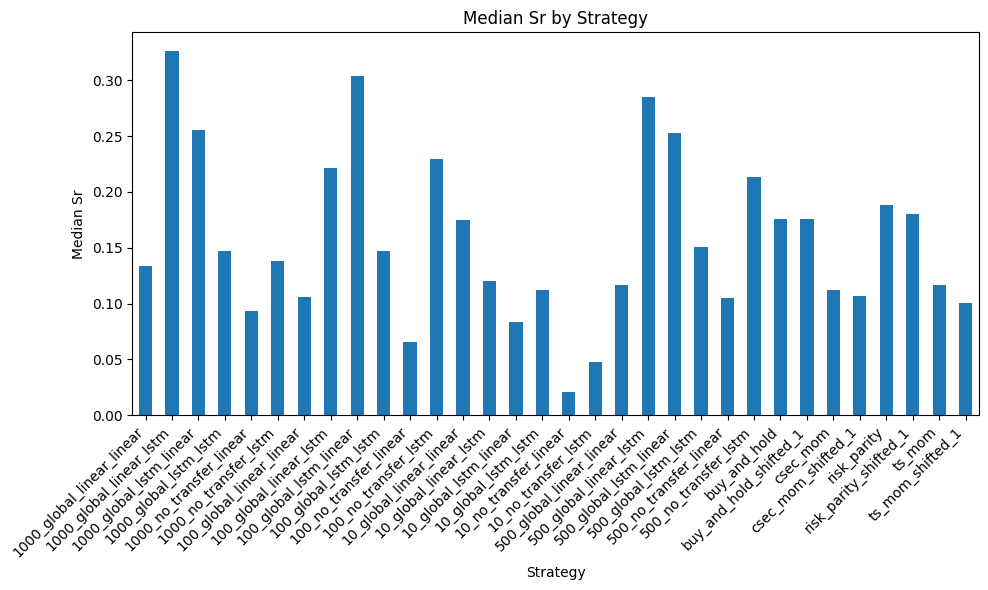

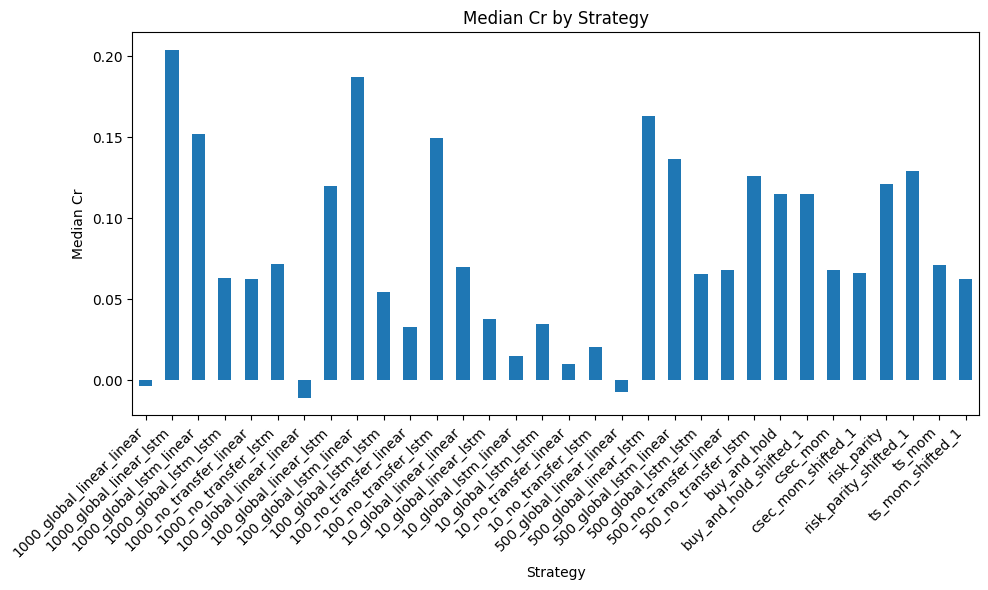

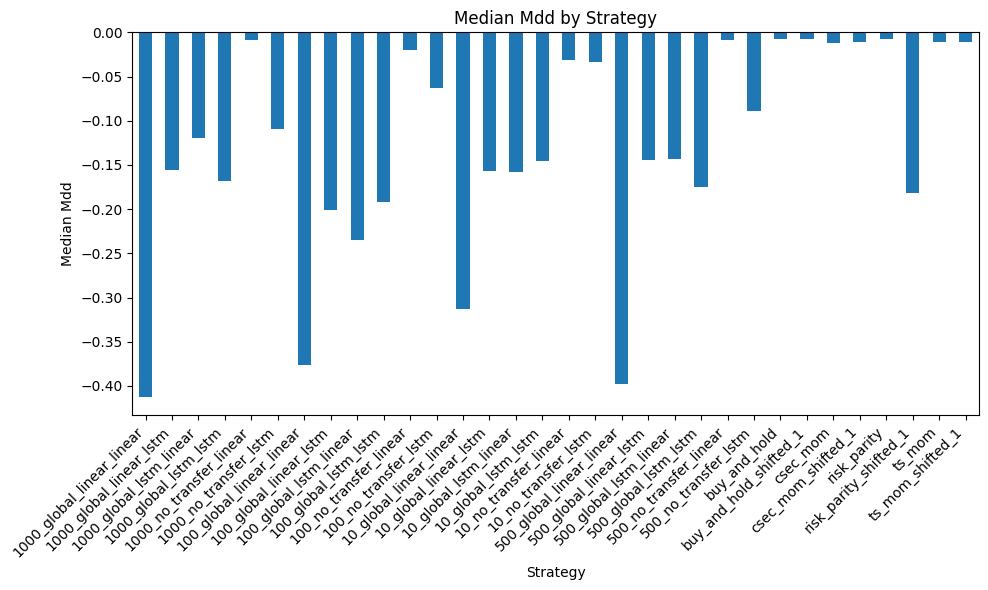

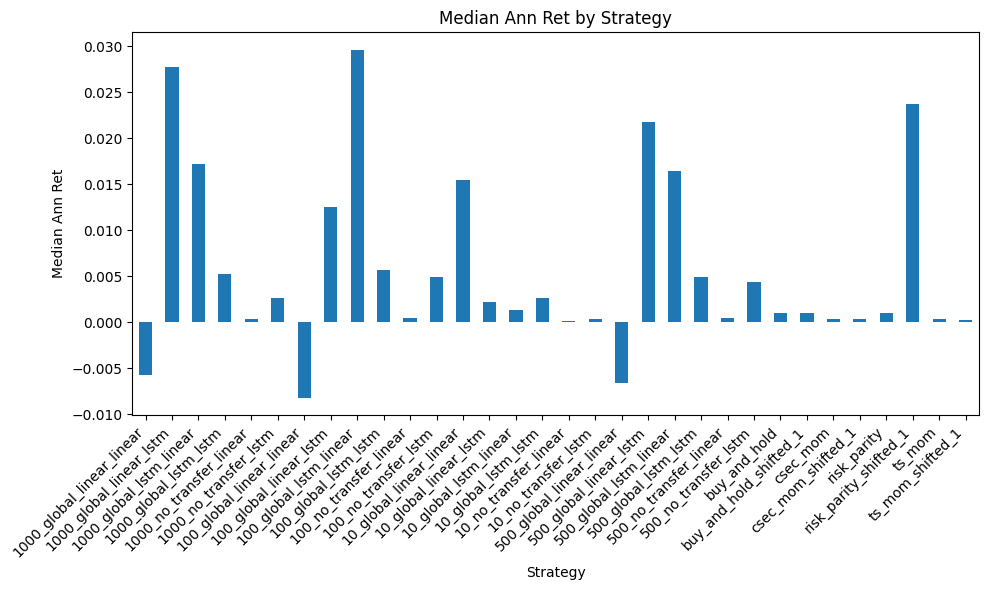

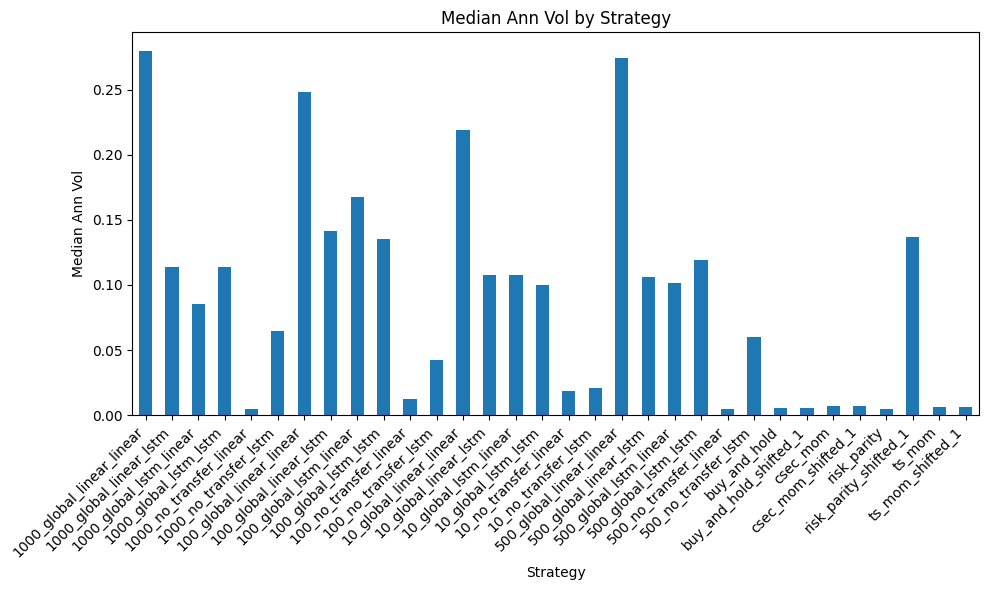

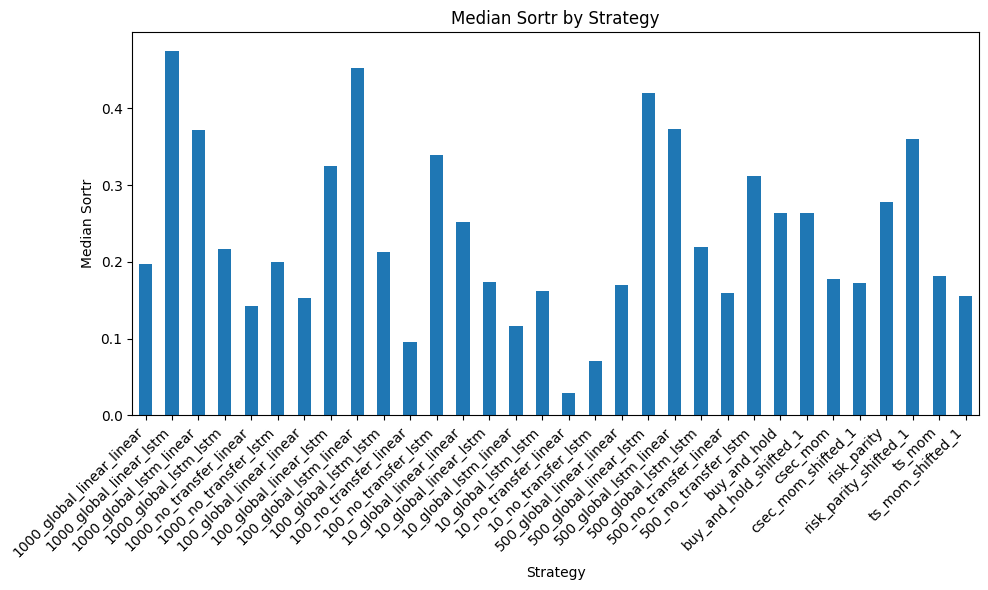

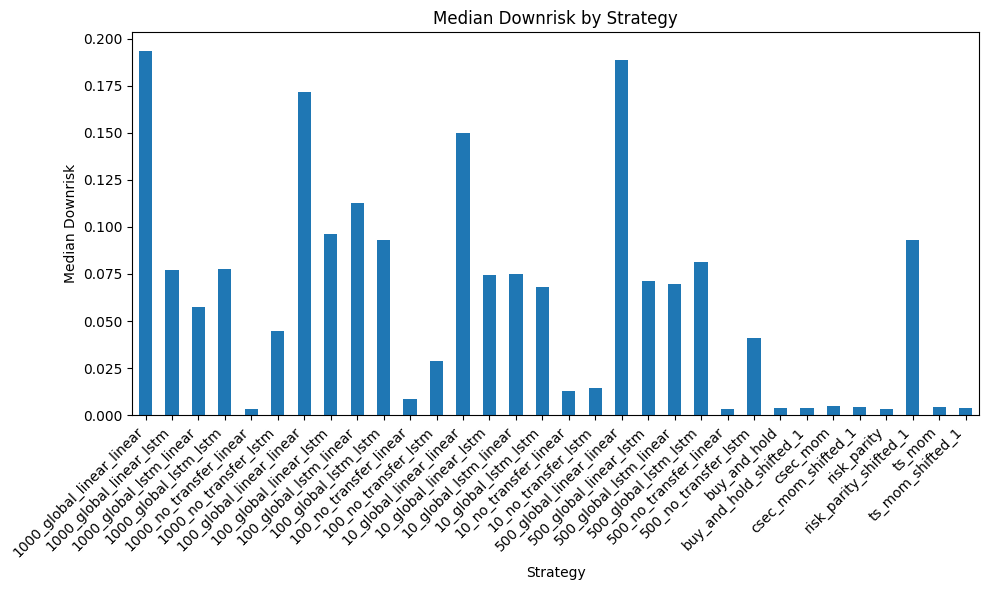

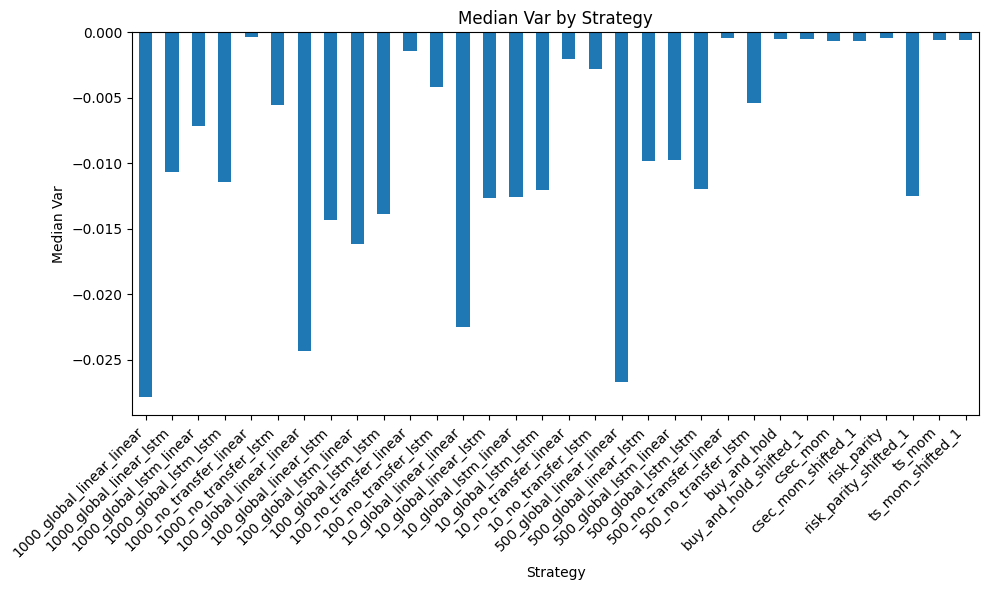

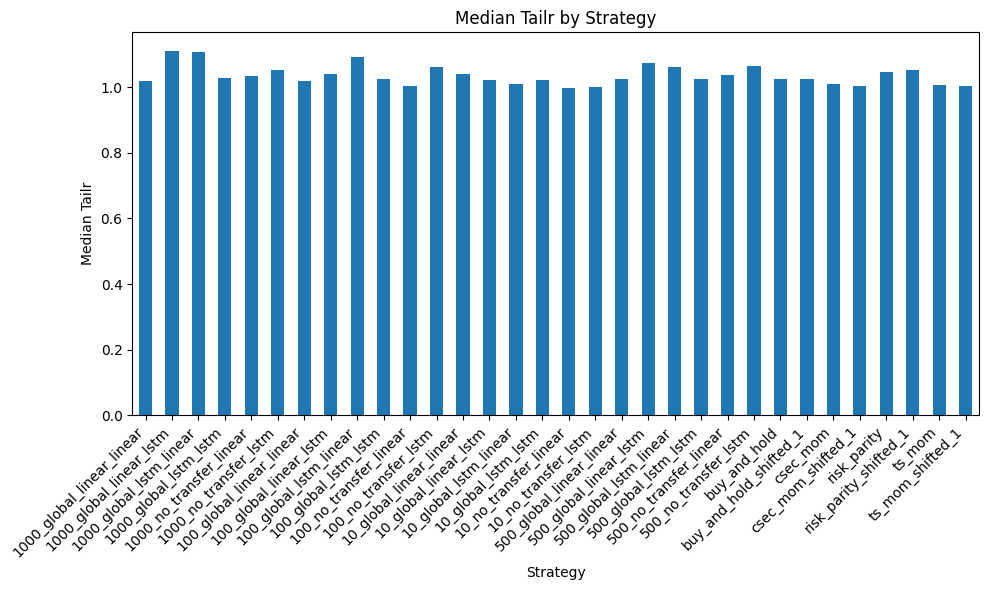

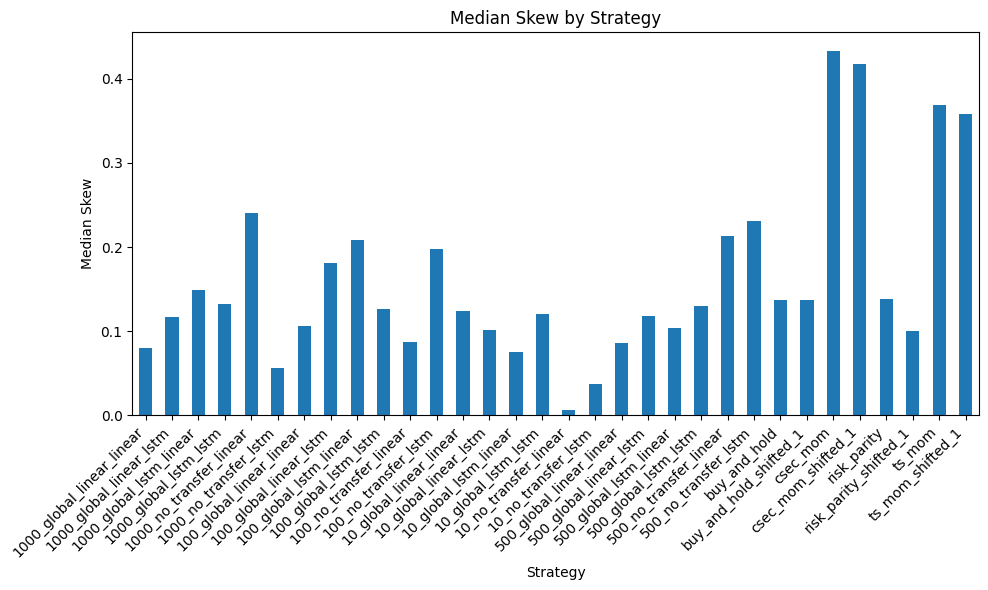

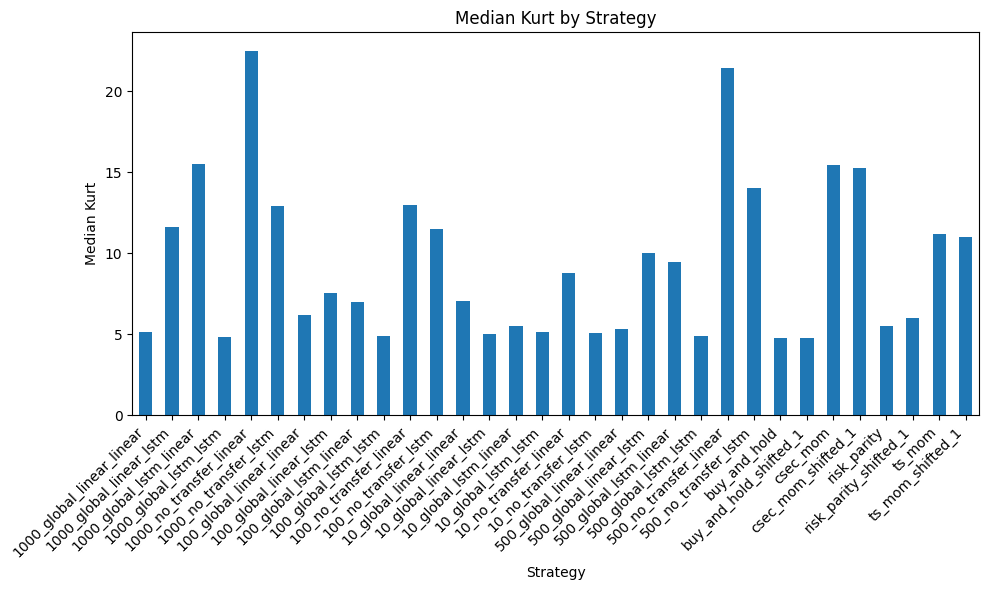

In [239]:
import matplotlib.pyplot as plt

# Automatically select median columns
median_metrics = [col for col in results_grouped.columns if col.startswith("median_")]

for metric in median_metrics:
    plt.figure(figsize=(10, 6))
    results_grouped[metric].plot(kind="bar")
    plt.title(f"{metric.replace('_', ' ').title()} by Strategy")
    plt.ylabel(metric.replace("_", " ").title())
    plt.xlabel("Strategy")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [240]:
results_grouped_rank = results_grouped.copy()
positive_rank_metrics = [
    "median_SR",
    "median_CR",
    "median_ANN_RET",
    "median_SortR",
]

for metric in positive_rank_metrics:
    results_grouped_rank[metric] = results_grouped_rank[metric].rank(
        ascending=False, method="min"
    )

negative_rank_metrics = [
    "median_MDD",
    "median_ANN_VOL",
    "median_DownRisk",
    "median_VaR",
    "median_TailR",
]

rank_metrics = positive_rank_metrics + negative_rank_metrics
for metric in negative_rank_metrics:
    results_grouped_rank[metric] = results_grouped_rank[metric].rank(
        ascending=True, method="min"
    )

results_grouped_rank = results_grouped_rank[rank_metrics]
results_grouped_rank

,median_SR,median_CR,median_ANN_RET,median_SortR,median_MDD,median_ANN_VOL,median_DownRisk,median_VaR,median_TailR
transferstrat,,,,,,,,,
1000_global_linear_linear,18.0,30.0,30.0,18.0,1.0,32.0,32.0,1.0,10.0
1000_global_linear_lstm,1.0,1.0,2.0,1.0,13.0,23.0,22.0,14.0,32.0
1000_global_lstm_linear,4.0,4.0,5.0,5.0,17.0,16.0,16.0,17.0,31.0
1000_global_lstm_lstm,15.0,20.0,10.0,15.0,10.0,22.0,23.0,13.0,18.0
1000_no_transfer_linear,28.0,22.0,24.0,28.0,29.0,1.0,1.0,32.0,19.0
1000_no_transfer_lstm,17.0,13.0,14.0,17.0,18.0,15.0,15.0,18.0,24.0
100_global_linear_linear,25.0,32.0,32.0,27.0,3.0,30.0,30.0,3.0,9.0
100_global_linear_lstm,7.0,10.0,8.0,8.0,6.0,27.0,27.0,6.0,22.0
100_global_lstm_linear,2.0,2.0,1.0,2.0,5.0,28.0,28.0,5.0,30.0


In [241]:
results_grouped_rank_total = results_grouped_rank.sum(axis=1)
results_grouped_rank_total

transferstrat
1000_global_linear_linear    172.0
1000_global_linear_lstm      109.0
1000_global_lstm_linear      115.0
1000_global_lstm_lstm        146.0
1000_no_transfer_linear      184.0
1000_no_transfer_lstm        151.0
100_global_linear_linear     191.0
100_global_linear_lstm       121.0
100_global_lstm_linear       103.0
100_global_lstm_lstm         144.0
100_no_transfer_linear       178.0
100_no_transfer_lstm         122.0
10_global_linear_linear      135.0
10_global_linear_lstm        151.0
10_global_lstm_linear        173.0
10_global_lstm_lstm          158.0
10_no_transfer_linear        189.0
10_no_transfer_lstm          182.0
500_global_linear_linear     184.0
500_global_linear_lstm       110.0
500_global_lstm_linear       115.0
500_global_lstm_lstm         145.0
500_no_transfer_linear       171.0
500_no_transfer_lstm         132.0
buy_and_hold                 131.0
buy_and_hold_shifted_1       131.0
csec_mom                     156.0
csec_mom_shifted_1           159.0
risk_p

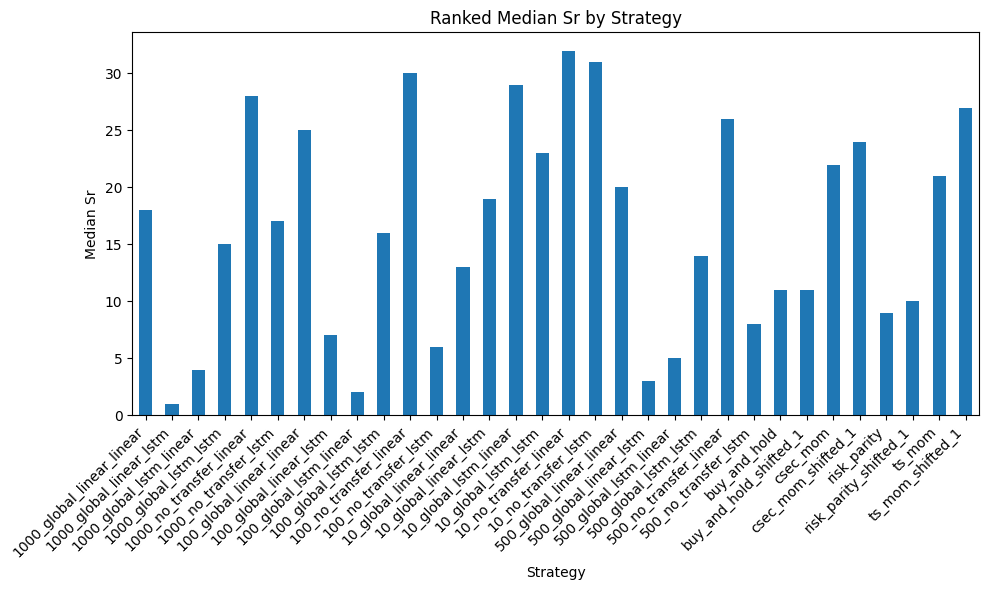

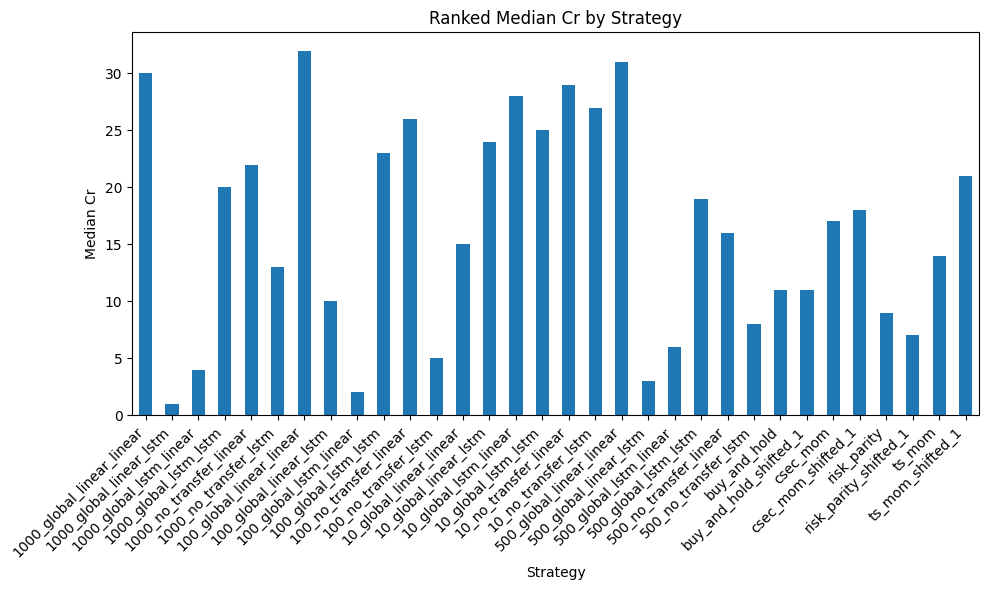

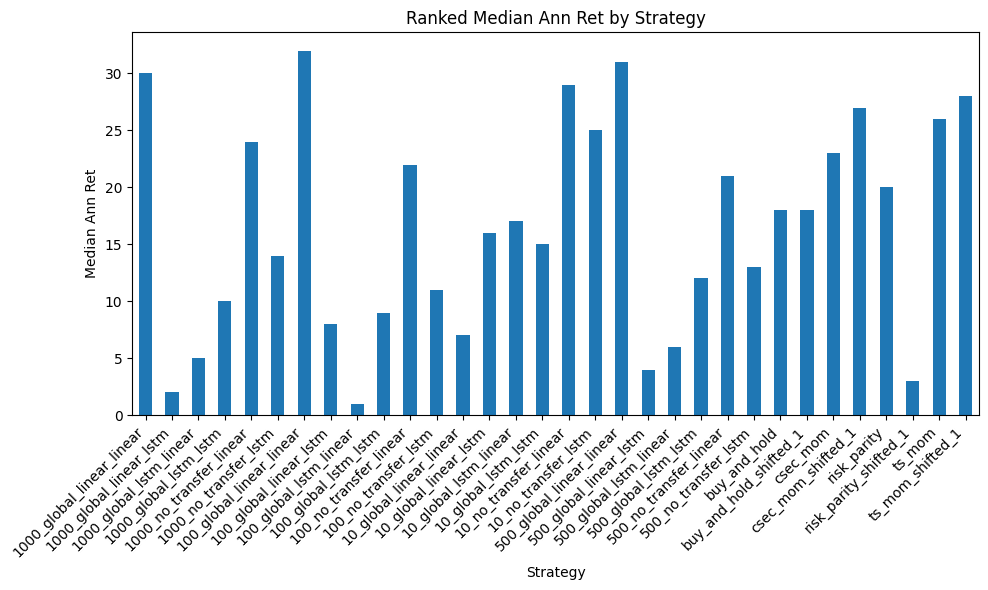

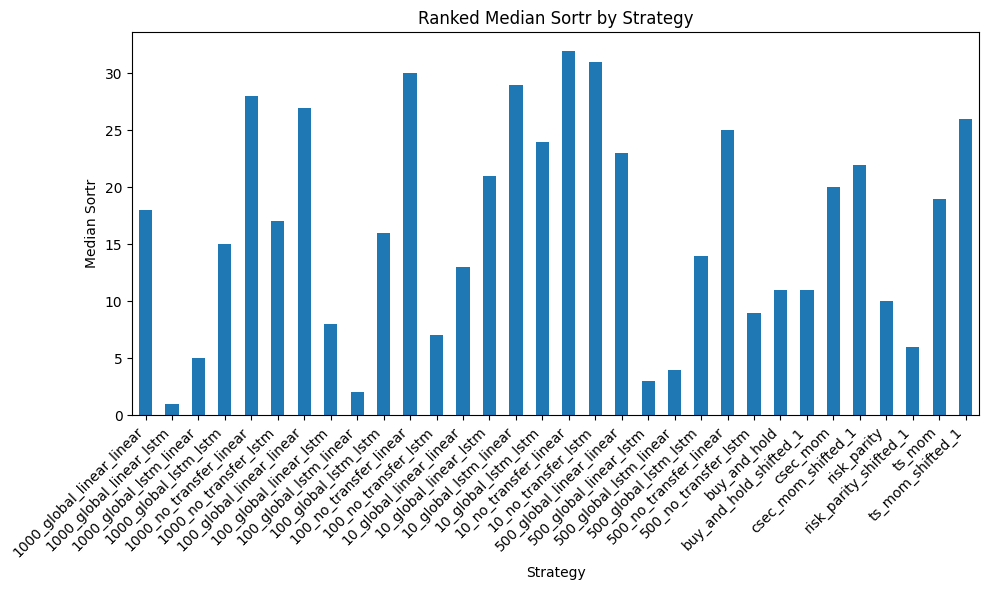

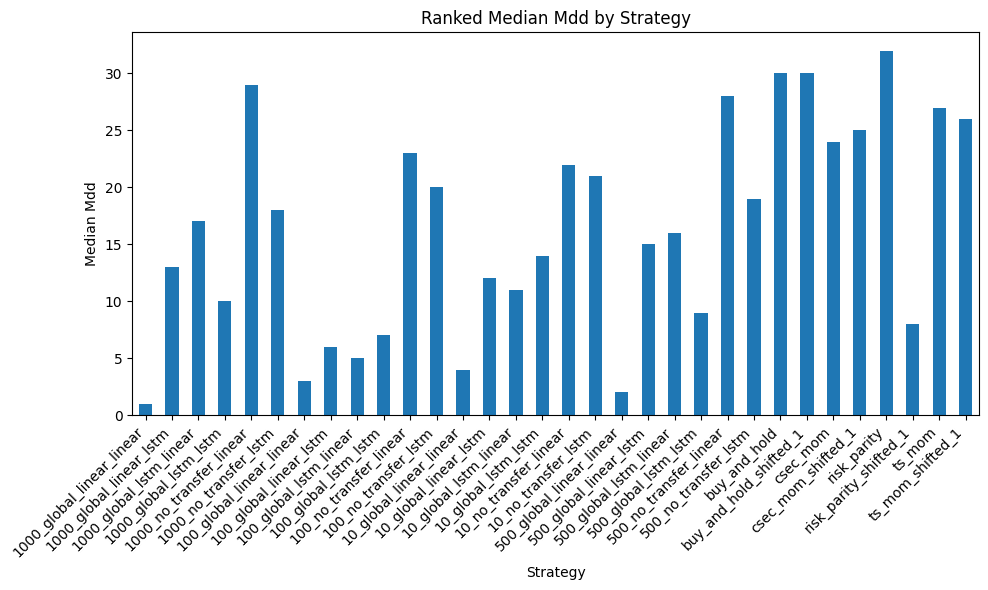

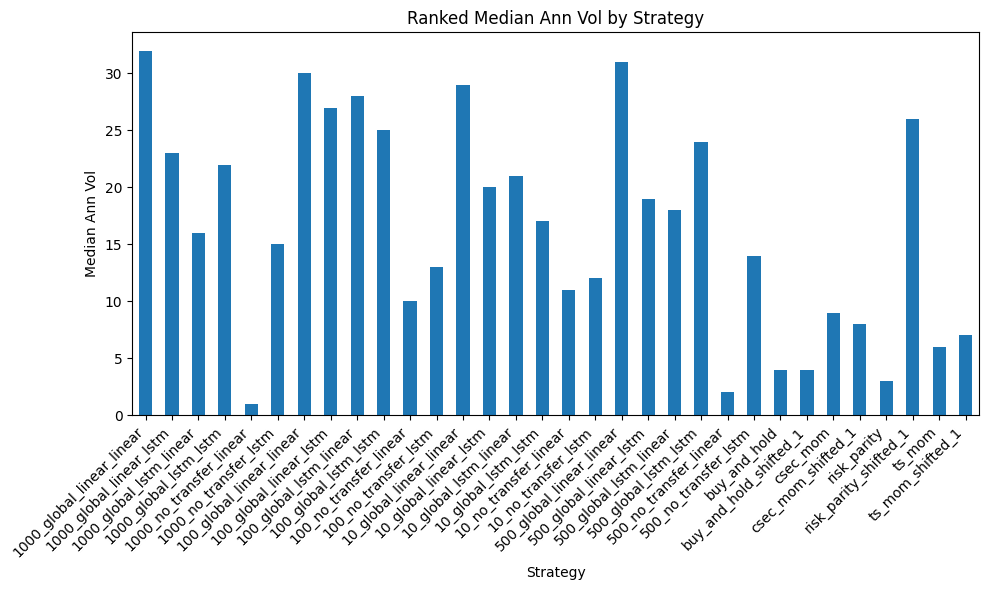

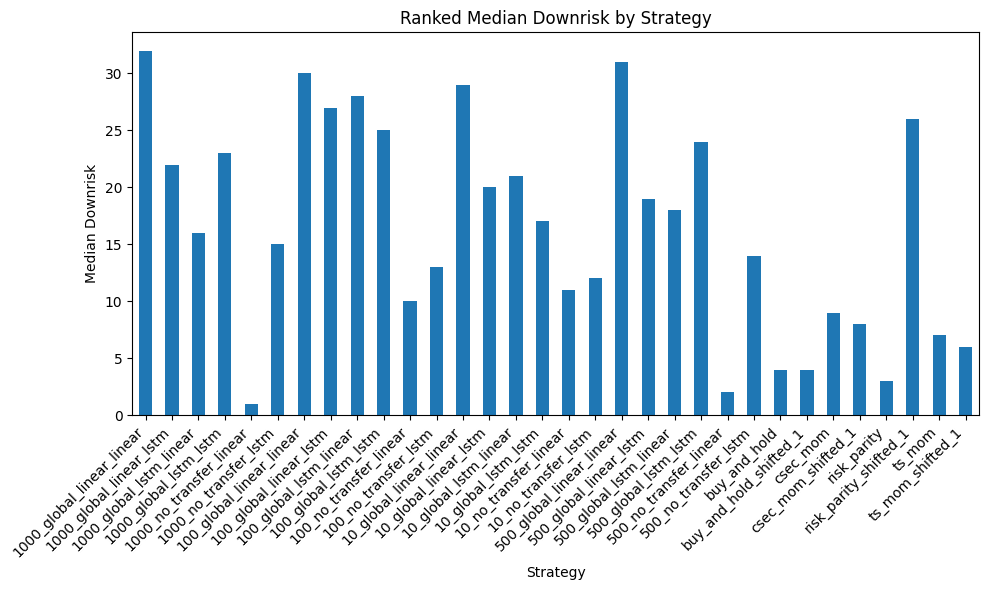

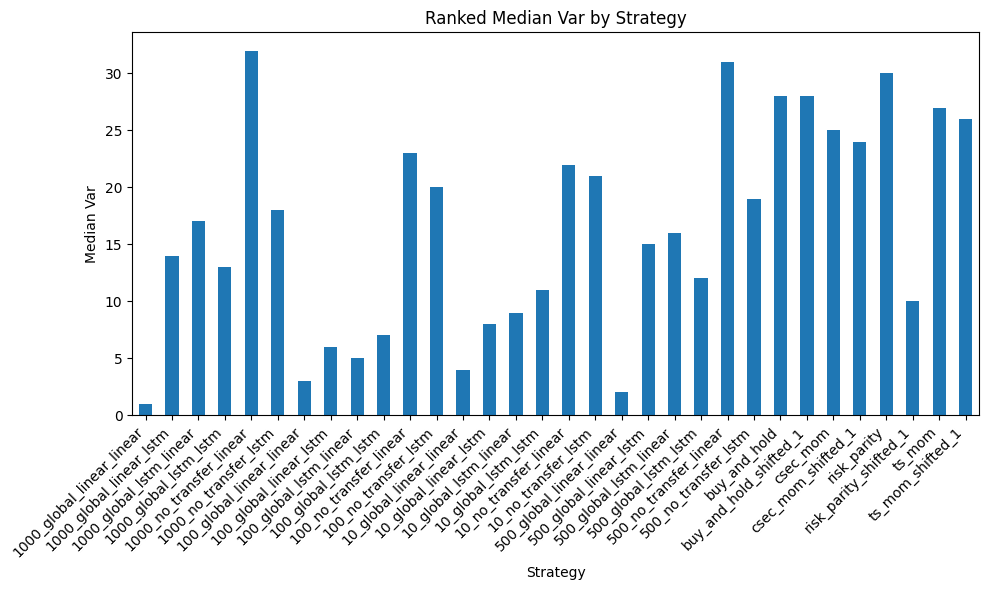

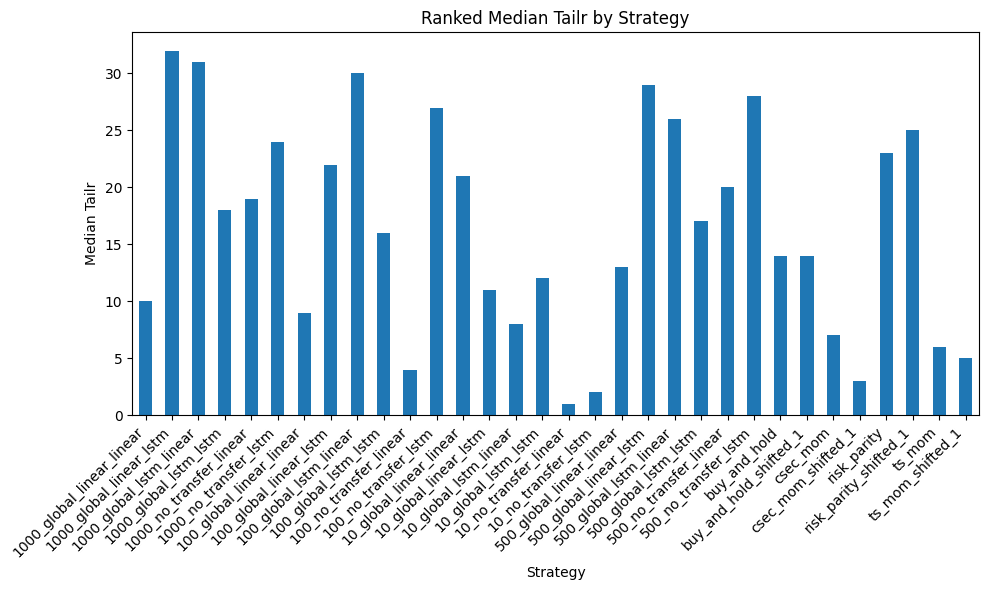

In [242]:
for metric in rank_metrics:
    plt.figure(figsize=(10, 6))
    results_grouped_rank[metric].plot(kind="bar")
    plt.title(f"Ranked {metric.replace('_', ' ').title()} by Strategy")
    plt.ylabel(metric.replace("_", " ").title())
    plt.xlabel("Strategy")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

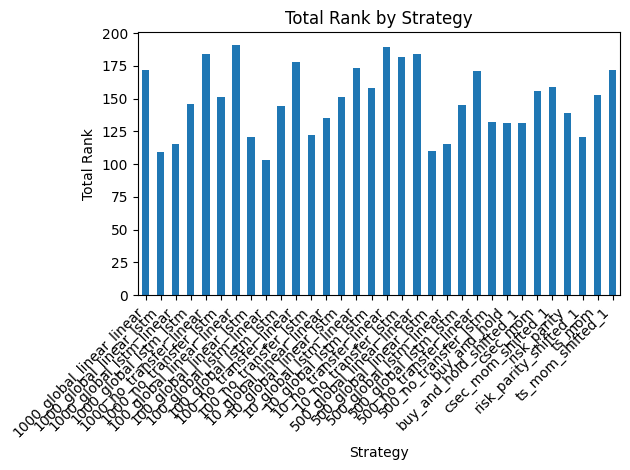

In [243]:
results_grouped_rank_total.plot(kind="bar")
plt.title("Total Rank by Strategy")
plt.ylabel("Total Rank")
plt.xlabel("Strategy")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [244]:
results_summary_baseline_grouped

,non_zero_count,median_SR,median_CR,median_MDD,median_ANN_RET,median_ANN_VOL,median_SortR,median_DownRisk,median_VaR,median_TailR,...,sd_CR,sd_MDD,sd_ANN_RET,sd_ANN_VOL,sd_SortR,sd_DownRisk,sd_VaR,sd_TailR,sd_Skew,sd_Kurt
transferstrat,,,,,,,,,,,,,,,,,,,,,
buy_and_hold,2212.500,0.175814,0.114672,-0.008090,0.000968,0.005296,0.263501,0.003574,-0.000481,1.025035,...,0.561904,0.014825,0.010821,0.010987,1.128509,0.005846,0.000666,0.066632,2.481754,52.619288
buy_and_hold_shifted_1,2212.500,0.175814,0.114672,-0.008090,0.000968,0.005296,0.263501,0.003574,-0.000481,1.025035,...,0.561904,0.014825,0.010821,0.010987,1.128509,0.005846,0.000666,0.066632,2.481754,52.619288
csec_mom,2212.500,0.111975,0.067837,-0.011514,0.000413,0.006969,0.177557,0.004634,-0.000683,1.011165,...,0.504186,0.046745,0.017676,0.032338,0.948320,0.016822,0.000994,0.054751,3.171010,63.454598
csec_mom_shifted_1,2212.500,0.106569,0.066042,-0.011378,0.000331,0.006941,0.172247,0.004613,-0.000686,1.003262,...,0.478825,0.045889,0.014710,0.030617,0.917303,0.014934,0.000999,0.052973,3.160728,61.841546
risk_parity,2212.500,0.188464,0.121219,-0.007470,0.000959,0.005141,0.277423,0.003494,-0.000436,1.047438,...,0.541862,0.014814,0.009288,0.008276,0.931626,0.005801,0.000665,0.070979,2.951096,62.717529
risk_parity_shifted_1,2205.375,0.179810,0.129079,-0.182207,0.023694,0.136686,0.359763,0.093094,-0.012539,1.054071,...,0.552794,0.076516,0.084787,0.036889,0.887144,0.024682,0.002836,0.058817,2.396026,48.071734
ts_mom,2212.500,0.116319,0.070834,-0.010516,0.000372,0.006090,0.182053,0.004113,-0.000589,1.006851,...,0.482669,0.041875,0.015786,0.029488,0.907195,0.015046,0.000862,0.054352,2.781115,54.459063
ts_mom_shifted_1,2212.500,0.100525,0.062620,-0.010653,0.000306,0.006096,0.155158,0.004066,-0.000592,1.004406,...,0.450578,0.041007,0.013025,0.028020,0.880354,0.013147,0.000868,0.051041,2.741728,53.364038


In [245]:
results_summary_models_grouped

,non_zero_count,median_SR,median_CR,median_MDD,median_ANN_RET,median_ANN_VOL,median_SortR,median_DownRisk,median_VaR,median_TailR,...,sd_CR,sd_MDD,sd_ANN_RET,sd_ANN_VOL,sd_SortR,sd_DownRisk,sd_VaR,sd_TailR,sd_Skew,sd_Kurt
transferstrat,,,,,,,,,,,,,,,,,,,,,
1000_global_linear_linear,2212.5,0.133717,-0.003770,-0.412460,-0.005703,0.279922,0.197282,0.193624,-0.027860,1.020536,...,1.375195,0.217968,0.302684,0.247597,1.315436,0.120947,0.005285,0.068866,2.420626,53.977216
1000_global_linear_lstm,2212.5,0.326534,0.204017,-0.156122,0.027692,0.113959,0.475406,0.076970,-0.010674,1.111998,...,1.125184,0.097728,0.107558,0.056373,1.136830,0.041205,0.002209,0.109238,2.681380,53.498228
1000_global_lstm_linear,2212.5,0.255744,0.151990,-0.119962,0.017161,0.085092,0.371770,0.057524,-0.007129,1.106759,...,1.425145,0.086959,0.121392,0.058957,1.548555,0.034310,0.002435,0.117057,3.340245,66.428753
1000_global_lstm_lstm,2212.5,0.147494,0.063302,-0.167827,0.005229,0.113644,0.216775,0.077551,-0.011416,1.027672,...,0.603141,0.132813,0.124849,0.108019,1.128818,0.055980,0.003531,0.064208,2.511051,53.454975
1000_no_transfer_linear,2212.5,0.093105,0.062116,-0.008280,0.000386,0.004788,0.141811,0.003238,-0.000393,1.032967,...,1.053352,0.010057,0.006724,0.005771,1.352357,0.003999,0.000173,0.107974,3.781000,68.595441
1000_no_transfer_lstm,2212.5,0.137661,0.071383,-0.109724,0.002698,0.064763,0.199916,0.044801,-0.005533,1.051312,...,1.234176,0.112443,0.092741,0.066161,1.082572,0.047011,0.004561,0.093212,2.840661,56.726619
100_global_linear_linear,2212.5,0.105507,-0.010954,-0.376063,-0.008202,0.248365,0.152422,0.171869,-0.024329,1.020103,...,1.566899,0.215148,0.291216,0.233103,1.427725,0.114770,0.005403,0.075739,2.483904,52.539121
100_global_linear_lstm,2212.5,0.221088,0.120073,-0.201383,0.012483,0.141488,0.325089,0.096100,-0.014356,1.041386,...,1.313445,0.142729,0.153122,0.121799,1.362056,0.059979,0.004249,0.099192,2.639021,54.390807
100_global_lstm_linear,2212.5,0.303546,0.187347,-0.235234,0.029622,0.167133,0.452207,0.112523,-0.016157,1.090989,...,1.506803,0.140069,0.200577,0.183952,1.374503,0.059478,0.003596,0.086027,2.395830,49.478058


In [246]:
results_summary_models_grouped.loc[
    ["1000_global_lstm_lstm", "1000_no_transfer_linear", "1000_no_transfer_lstm"]
]

,non_zero_count,median_SR,median_CR,median_MDD,median_ANN_RET,median_ANN_VOL,median_SortR,median_DownRisk,median_VaR,median_TailR,...,sd_CR,sd_MDD,sd_ANN_RET,sd_ANN_VOL,sd_SortR,sd_DownRisk,sd_VaR,sd_TailR,sd_Skew,sd_Kurt
transferstrat,,,,,,,,,,,,,,,,,,,,,
1000_global_lstm_lstm,2212.5,0.147494,0.063302,-0.167827,0.005229,0.113644,0.216775,0.077551,-0.011416,1.027672,...,0.603141,0.132813,0.124849,0.108019,1.128818,0.055980,0.003531,0.064208,2.511051,53.454975
1000_no_transfer_linear,2212.5,0.093105,0.062116,-0.008280,0.000386,0.004788,0.141811,0.003238,-0.000393,1.032967,...,1.053352,0.010057,0.006724,0.005771,1.352357,0.003999,0.000173,0.107974,3.781000,68.595441
1000_no_transfer_lstm,2212.5,0.137661,0.071383,-0.109724,0.002698,0.064763,0.199916,0.044801,-0.005533,1.051312,...,1.234176,0.112443,0.092741,0.066161,1.082572,0.047011,0.004561,0.093212,2.840661,56.726619


### Table 1

In [247]:
def get_table_1(results_summary_baseline_grouped, results_summary_models_grouped):
    cleaned_results_summary_baseline_grouped = results_summary_baseline_grouped[
        ~results_summary_baseline_grouped.index.astype(str).str.endswith("shifted_1")
    ]
    cleaned_results_summary_baseline_grouped = (
        cleaned_results_summary_baseline_grouped.drop(columns=["non_zero_count"])
    )

    cleaned_results_summary_models_grouped = results_summary_models_grouped.loc[
        ["1000_global_lstm_lstm", "1000_no_transfer_linear", "1000_no_transfer_lstm"]
    ]

    output_df = pd.concat(
        [
            cleaned_results_summary_baseline_grouped,
            cleaned_results_summary_models_grouped,
        ]
    )
    output_df = output_df.rename(
        index={
            "buy_and_hold": "Buy and hold",
            "risk_parity": "Risk_parity",
            "ts_mom": "TS Mom",
            "csec_mom": "CS Mom",
            "1000_no_transfer_linear": "No Transfer Linear",
            "1000_no_transfer_lstm": "No Transfer LSTM",
            "1000_global_lstm_lstm": "QuantNet",
        }
    )

    return output_df

In [248]:
table_1 = get_table_1(results_summary_baseline_grouped, results_summary_models_grouped)
table_1.to_csv("table_1.csv")
table_1

,median_SR,median_CR,median_MDD,median_ANN_RET,median_ANN_VOL,median_SortR,median_DownRisk,median_VaR,median_TailR,median_Skew,...,sd_MDD,sd_ANN_RET,sd_ANN_VOL,sd_SortR,sd_DownRisk,sd_VaR,sd_TailR,sd_Skew,sd_Kurt,non_zero_count
transferstrat,,,,,,,,,,,,,,,,,,,,,
Buy and hold,0.175814,0.114672,-0.008090,0.000968,0.005296,0.263501,0.003574,-0.000481,1.025035,0.136432,...,0.014825,0.010821,0.010987,1.128509,0.005846,0.000666,0.066632,2.481754,52.619288,NaN
CS Mom,0.111975,0.067837,-0.011514,0.000413,0.006969,0.177557,0.004634,-0.000683,1.011165,0.433594,...,0.046745,0.017676,0.032338,0.948320,0.016822,0.000994,0.054751,3.171010,63.454598,NaN
Risk_parity,0.188464,0.121219,-0.007470,0.000959,0.005141,0.277423,0.003494,-0.000436,1.047438,0.138006,...,0.014814,0.009288,0.008276,0.931626,0.005801,0.000665,0.070979,2.951096,62.717529,NaN
TS Mom,0.116319,0.070834,-0.010516,0.000372,0.006090,0.182053,0.004113,-0.000589,1.006851,0.368555,...,0.041875,0.015786,0.029488,0.907195,0.015046,0.000862,0.054352,2.781115,54.459063,NaN
QuantNet,0.147494,0.063302,-0.167827,0.005229,0.113644,0.216775,0.077551,-0.011416,1.027672,0.132192,...,0.132813,0.124849,0.108019,1.128818,0.055980,0.003531,0.064208,2.511051,53.454975,2212.5
No Transfer Linear,0.093105,0.062116,-0.008280,0.000386,0.004788,0.141811,0.003238,-0.000393,1.032967,0.240033,...,0.010057,0.006724,0.005771,1.352357,0.003999,0.000173,0.107974,3.781000,68.595441,2212.5
No Transfer LSTM,0.137661,0.071383,-0.109724,0.002698,0.064763,0.199916,0.044801,-0.005533,1.051312,0.056026,...,0.112443,0.092741,0.066161,1.082572,0.047011,0.004561,0.093212,2.840661,56.726619,2212.5


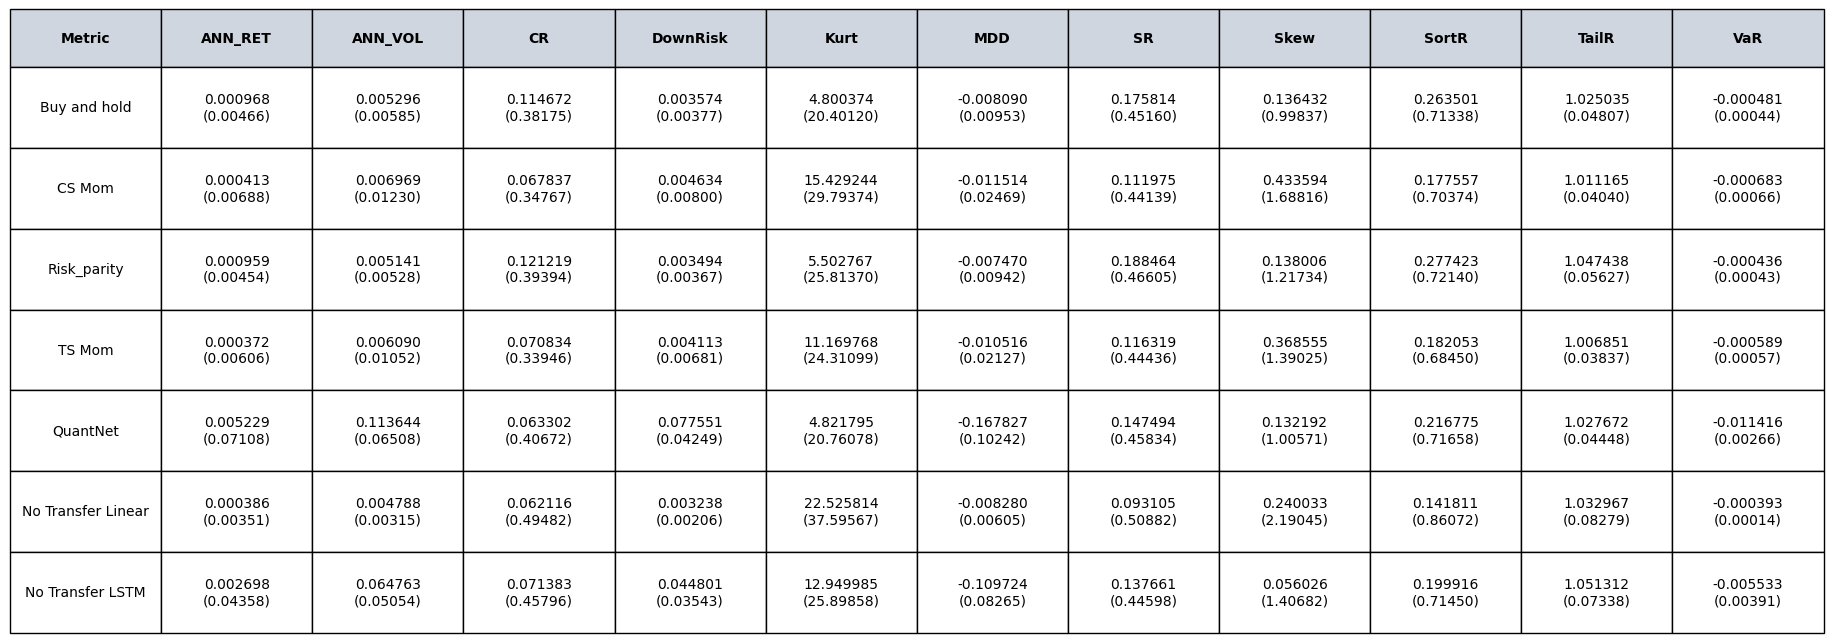

In [249]:
draw_table(df=table_1, upper_prefix="median", lower_prefix="mad")